# Fallout Model

In the following Notebook, we use open data from Environment Canada weather stations to model the wind speeds and directions in the Montreal area. Using these models, we will simulate possible paths for the fallout, should WW3 actually happen and an atomic bomb be dropped on the city.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from datetime import datetime
from folium import Map, Circle, Marker
from threading import Thread, Lock
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from typing import Union

pd.set_option('mode.chained_assignment', None)
PLOT_COLOR = "limegreen"
URL_ENV_CAN = "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID="
URL_ENV_CAN += "{}&Year={}&Month={}&Day=1&timeframe=1"
MT_ROYAL_COORDINATES = (45.505, -73.588)
YUL = 30165 # ID of the Pierre-Elliott-Trudeau international airport station
MAP_ARGS = {
    "tiles": "openstreetmap",
    "zoom_start": 9
}

stations = pd.read_csv("stations.csv", index_col=0)
stations.head()

,first_m,first_y,last_m,last_y
30165,1,2008,4,2022
10761,2,1994,4,2022
51157,2,2013,4,2022
10790,2,1994,11,2007
26855,11,1994,3,2008


Let's gather a bit more info on the different stations we can use:

In [2]:
additional_data = []
for i, row in enumerate(stations.iterrows()):
    station_id, time_range = row
    m, y = time_range.first_m, time_range.first_y
    data = pd.read_csv(URL_ENV_CAN.format(station_id, y, m)).iloc[0]
    lat, long, name = data[["Latitude (y)", "Longitude (x)", "Station Name"]].tolist()
    print(f"{station_id}\t=> {lat} / {long}\t=> {name}")
    additional_data.append([lat, long, name])
    
stations = pd.concat([
    stations,
    pd.DataFrame(
        additional_data,
        columns = ["lat", "long", "name"],
        index = stations.index
    )
], axis=1)
print(stations.shape)
stations.head()

30165	=> 45.47 / -73.74	=> MONTREAL/PIERRE ELLIOTT TRUDEAU INTL
10761	=> 45.5 / -73.58	=> MCTAVISH
51157	=> 45.47 / -73.74	=> MONTREAL INTL A
10790	=> 45.58 / -73.49	=> ILE CHARRON
26855	=> 45.63 / -73.55	=> MONTREAL-EST
48374	=> 45.52 / -73.42	=> MONTREAL/ST-HUBERT
5490	=> 45.52 / -73.42	=> MONTREAL/ST-HUBERT A
42783	=> 45.33 / -73.58	=> SAINT-CONSTANT
10873	=> 45.43 / -73.93	=> STE-ANNE-DE-BELLEVUE 1
42007	=> 45.32 / -73.91	=> BEAUHARNOIS
26856	=> 45.72 / -73.38	=> VARENNES
10843	=> 45.29 / -73.35	=> L'ACADIE
5616	=> 45.67 / -74.03	=> MONTREAL/MIRABEL INT'L A
49608	=> 45.68 / -74.04	=> MONTREAL MIRABEL INTL A
5237	=> 45.81 / -73.43	=> L'ASSOMPTION
42604	=> 45.19 / -73.62	=> SAINT-MICHEL-DE-NAPIERVILLE
42903	=> 45.85 / -73.7	=> SAINT-LIN-LAURENTIDES
10762	=> 45.17 / -73.68	=> STE-CLOTILDE
42008	=> 45.17 / -73.87	=> HOWICK
42784	=> 45.13 / -73.77	=> SAINT-CHRYSOSTOME
42643	=> 45.12 / -73.68	=> RUISSEAU CRANBERRY
42011	=> 45.41 / -73.05	=> ROUGEMONT
41737	=> 45.48 / -74.29	=> RIGAUD 2
4

,first_m,first_y,last_m,last_y,lat,long,name
30165,1,2008,4,2022,45.47,-73.74,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL
10761,2,1994,4,2022,45.50,-73.58,MCTAVISH
51157,2,2013,4,2022,45.47,-73.74,MONTREAL INTL A
10790,2,1994,11,2007,45.58,-73.49,ILE CHARRON
26855,11,1994,3,2008,45.63,-73.55,MONTREAL-EST


Where are they located?

In [3]:
viz_map = Map(location=MT_ROYAL_COORDINATES, **MAP_ARGS)
for _, row in stations.iterrows():
    Marker((row.lat, row.long)).add_to(viz_map)
viz_map

## Individual station model

In [4]:
station = stations.loc[YUL]
m, y = station.first_m, station.first_y
data = pd.read_csv(URL_ENV_CAN.format(YUL, y, m))
print(data.shape)
data.columns

(744, 30)


Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time (LST)', 'Year', 'Month', 'Day', 'Time (LST)', 'Temp (°C)',
       'Temp Flag', 'Dew Point Temp (°C)', 'Dew Point Temp Flag',
       'Rel Hum (%)', 'Rel Hum Flag', 'Precip. Amount (mm)',
       'Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather'],
      dtype='object')

We are interested in the `Wind Dir (10s deg)` and `Wind Spd (km/h)` columns.

In [5]:
index_cols = ['Year', 'Month', 'Day', 'Time (LST)']
target_cols = ['Wind Dir (10s deg)', 'Wind Spd (km/h)']
keep = [*index_cols, *target_cols]

Let us create a class to import and handle a station's data:

In [6]:
class StationData():
    
    def __init__(self,
                 station_data,
                 index_columns = index_cols,
                 target_columns = target_cols):
        self.id = station_data.name
        self.meta = station_data
        self.mutex = Lock()
        self.index = index_columns
        self.targets = target_cols
        self.data = pd.DataFrame(columns=[*index_columns, *target_columns])

    def get_monthly_data(self, month, year, url=URL_ENV_CAN):
        try:
            monthly = pd.read_csv(url.format(self.id, year, month))
            monthly = monthly[self.data.columns]
            self.mutex.acquire()
            self.data = pd.concat([self.data, monthly], axis=0)
            self.mutex.release()
        except Exception as e:
            print(f"Unable to collect data for {str(month).zfill(2)}/{year} ({type(e)})")
        
    def load_data(self,
                  url = URL_ENV_CAN,
                  index = index_cols,
                  min_year = 0,
                  max_year = datetime.today().year):
        # Define which month/year combinations are valid
        m, y = self.meta.first_m, max(min_year, self.meta.first_y)
        last = (self.meta.last_m, min(max_year, self.meta.last_y))
        if y > last[1] or (y == last[1] and m > last[0]):
            msg = f"""Starting month is later than the supposed ending!
                   \r\nStart: {m,y}\nEnd: {last}"""
            raise ValueError(msg)
        periods = [(m, y)]
        while (m, y) != last:
            m += 1
            if m == 13:
                y += 1
                m = 1
            periods.append((m, y))
        # Distribute the tasks
        threads = []
        for m, y in periods:
            t = Thread(
                target = self.get_monthly_data,
                args = (m, y, url)
            )
            t.start()
            threads.append(t)
        # Wait for the threads to finish
        for t in tqdm(threads):
            t.join()
        self.data.columns = [*self.data.columns[:-2], "direction", "speed"]
        # Replace missing speeds with 0
        self.data.speed = self.data.speed.fillna(0)
        # 360 degrees is the same as 0
        self.data.direction.iloc[np.where(self.data.direction == 36)[0]] = 0
        # Convert 10's of degrees into degrees
        self.data.direction *= 10
        self.data = self.data.sort_values(index, ascending=True).reset_index(drop=True)
            
model = StationData(stations.loc[YUL])
model.load_data()
data = model.data
print(data.shape)
data.head()

100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [00:17<00:00,  9.99it/s]


(125616, 6)


,Year,Month,Day,Time (LST),direction,speed
0,2008,1,1,00:00,NaN,0.0
1,2008,1,1,01:00,NaN,0.0
2,2008,1,1,02:00,NaN,0.0
3,2008,1,1,03:00,NaN,0.0
4,2008,1,1,04:00,NaN,0.0


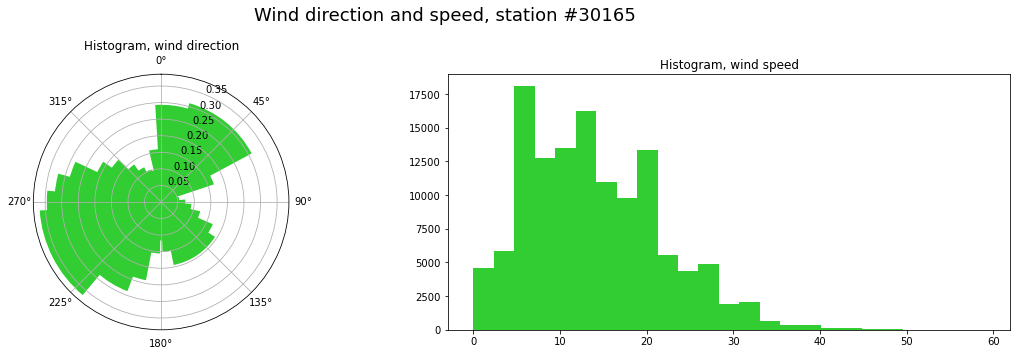

In [7]:
plt.figure(figsize=(16, 5))

# Wind direction
d = data.direction.dropna().to_numpy().astype(int)
density, bins = np.histogram(np.deg2rad(d), bins=36, density=True)
ax = plt.subplot(121, polar=True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.bar(bins[:-1], density, color=PLOT_COLOR)
ax.set_title("Histogram, wind direction")

# Wind speed
ax = plt.subplot(122)
ax.hist(data.speed.dropna(), bins=25, color=PLOT_COLOR)
ax.set_title("Histogram, wind speed")

plt.suptitle(f"Wind direction and speed, station #{YUL}", fontsize=18)
plt.tight_layout()
plt.show()

Since the distribution of the wind's direction has three distinct local modes, we are probably better off using a nonparametric distribution for simulations.  

Let us see if the distribution of wind speeds should be conditioned on the wind's direction:

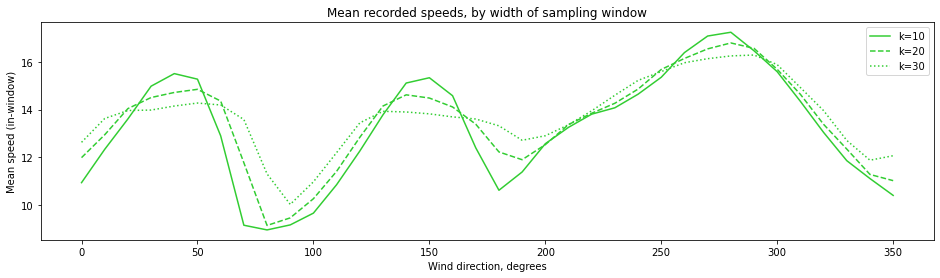

In [8]:
def sample_speeds(data, direction, k=15):
    k %= 180
    direction %= 360
    obs_dir = data.direction
    lower = obs_dir <= direction
    higher = obs_dir >= direction
    if direction - k >= 0:
        lb_condition = (lower & (obs_dir >= direction - k))
    else:
        lb_condition = (lower | (obs_dir >= 360 + direction - k))
    if direction + k < 360:
        ub_condition = (higher & (obs_dir <= direction + k))
    else:
        ub_condition = (higher | (obs_dir <= direction - 360 + k))
    speeds = data.loc[lb_condition | ub_condition].speed
    return speeds.to_numpy()

directions = np.arange(36) * 10
means = lambda d, k: sample_speeds(data, d, k).mean()
plt.figure(figsize=(16,4))
styles = ["solid", "dashed", "dotted"]
for i, k in enumerate([10, 20, 30]):
    plt.plot(directions,
             [means(d, k) for d in directions], 
             color = PLOT_COLOR,
             label = f"k={k}", 
             linestyle = styles[i])
plt.legend()
plt.xlabel("Wind direction, degrees")
plt.ylabel("Mean speed (in-window)")
plt.title("Mean recorded speeds, by width of sampling window")
plt.show()

Clearly, we're going to have to consider the wind's direction when simulating its speed.  

Another piece of information to consider is the lagged dependence of the data: if, at time $t$, the wind is blowing at a certain speed in a certain direction, its speed and direction at time $t+1$ will often be similar. It would therefore make sense to model wind speeds and directions as autoregressive stochastic processes. Let's start with speed, which should be the most straightforward of the two:

With AIC:
Best model: p = 8
Score: 14.53890460327445
RMSE: 3.8129727641697255
Intercept: 1.6878221302847614
Coefficients: [[ 0.73657291  0.13106295  0.02843424  0.00353528  0.002259   -0.00640586
  -0.00767318 -0.00849463]]

With BIC:
Best model: p = 8
Score: 14.53960255476661
RMSE: 3.8129727641697255
Intercept: 1.6878221302847614
Coefficients: [[ 0.73657291  0.13106295  0.02843424  0.00353528  0.002259   -0.00640586
  -0.00767318 -0.00849463]]


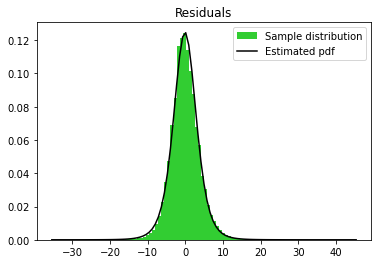

In [9]:
def lagged_data(data, p=1, add_intercept=True):
    n = data.shape[0] - p
    matrix = np.ones((n, p)) * np.nan
    for i in range(p):
        matrix[:, i] = data[(p-(i+1)):-(i+1)]
    if add_intercept:
        matrix = np.concatenate([np.ones((n,1)), matrix], axis=1)
    return matrix

def AIC(e, m):
    return np.var(e) + 2 * m / e.shape[0]

def BIC(e, m):
    T = e.shape[0]
    return np.var(e) + m * np.log(T) / T

def fit_single_model(X, y):
    model = LinearRegression()
    model.fit(X, y)
    model.residuals = y - model.predict(X)
    return model
        
def prep_data_continuous(p, data, *args, **kwargs):
    X = lagged_data(data, p, add_intercept=False)
    y = data[p:, np.newaxis]
    return X, y


class ARModel():
    
    def fit_error_model(self, graph=False, nbins=100, *args, **kwargs):
        e = self.model.residuals.flatten()
        self.error_model = sps.t(*sps.t.fit(e))
        if graph:
            plt.hist(
                e, 
                color = PLOT_COLOR,
                bins = nbins, 
                density = True, 
                label = "Sample distribution")
            x = np.linspace(e.min(), e.max(), nbins + 1)
            y = self.error_model.pdf(x)
            plt.plot(x, y, color="black", label="Estimated pdf")
            plt.legend()
            plt.title("Residuals")
            plt.show()
    
    def fit(self, 
            data: np.ndarray,
            transform: callable = lambda x, *a, **k: x,
            prep_data: callable = prep_data_continuous,
            p: int = None,
            max_p: int = 10,
            IC: callable = AIC,
            graph_selection: bool = False,
            graph_residuals: bool = False,
            verbose: bool = False,
            *args, **kwargs):
        
        data = transform(data, *args, **kwargs)
        if p is None:
            candidates, scores = [], []
            p_vec = np.arange(1, max_p + 1)
            for p in p_vec:
                X, y = prep_data(p, data, *args, **kwargs)
                candidate = fit_single_model(X, y)
                score = IC(candidate.residuals, p + 1)
                candidates.append(candidate)
                scores.append(score)
            if graph_selection:
                plt.plot(p_vec, scores)
                plt.xlabel("Lag")
                plt.ylabel("Score")
                plt.title("Model selection")
                plt.show()
            self.p = np.argmin(scores) + 1
            self.model = candidates[self.p - 1]
            if verbose:
                print(f"Best model: p = {self.p}\nScore: {min(scores)}")
        else:
            self.p = p
            self.model = fit_single_model(p, data)
            if verbose:
                print(f"Model: p = {self.p}")
        
        if verbose:
            print(f"""RMSE: {np.sqrt((self.model.residuals ** 2).mean())}
                  \rIntercept: {self.model.intercept_[0]}
                  \rCoefficients: {self.model.coef_}""")
        self.fit_error_model(graph=graph_residuals, *args, **kwargs)
    
speeds = data.speed.to_numpy()
ar_model = ARModel()
print("With AIC:")
ar_model.fit(speeds, IC=AIC, verbose=True)
print("\nWith BIC:")
ar_model.fit(speeds, IC=BIC, verbose=True, graph_residuals=True)

Dealing with direction will be a bit more complicated: if $\theta$ represents the wind's direction in degrees, we have that $\theta\in[0, 360[$. However, if $\theta_a=c$ and $\theta_b=c+360k$, then for any $k\in\mathbb{Z}$, $\theta_1=\theta_2$. In other words, if $\theta_t=350$ and $\theta_{t+1}=0$, the difference is a mere 10 degrees, but if we don't provide for such cases the difference will be understood to be 35 times that magnitude!  

We will handle this problem by working with the integrated series $\Delta_t\equiv\theta_t-\theta_{t-1}$, which we will transform so that where $|\Delta_t|\div180>0$, we take instead $(|\Delta_t|\%180)\times sign(-\Delta_t)$.  

Furthermore, we need to handle discontinuities in the data: while missing values for wind speeds can probably be assumed to equal zero, two periods of wind, separated by a period of no wind, could blow in very different directions. If we simply drop missing direction values and concatenate the rest, such instance could wreak havoc on our model's fitness.

[-20. -10. -40. -10. -10.]


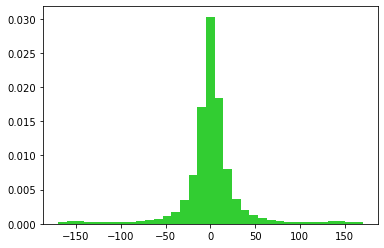

In [10]:
def continuous_angle_diffs(data, period=180, diffed=False):
    if np.isnan(data).any():
        print(data)
        raise ValueError("Missing values need to be purged before.")
    if not diffed:
        data = np.diff(data)
    mod = lambda d: np.absolute(d) % period * np.sign(-d)
    adjust_idx = np.where(np.absolute(data) // period != 0)[0]
    data[adjust_idx] = mod(data[adjust_idx])
    return data

def sequential_angles(data, period=180, *args, **kwargs):
    if data.dtype == 'object':
        data = data.astype(float)
    non_null = np.where(~np.isnan(data))[0]
    jumps = np.where(np.diff(non_null) > 1)[0] + 1
    jumps = np.append(jumps, [-1])
    segments = [continuous_angle_diffs(
        data[non_null[0]:(non_null[jumps[0]] - 1)],
        period = period
    )]
    for i in range(1, len(jumps)):
        start = non_null[jumps[i-1]]
        end = non_null[jumps[i] - 1]
        segments.append(continuous_angle_diffs(
            data[start:end],
            period = period
        ))
    return segments

directions = data.direction.to_numpy()
segments = sequential_angles(directions)
print(segments[0])
plt.hist(np.concatenate(segments), bins=35, density=True, color=PLOT_COLOR)
plt.show()

With AIC:
Best model: p = 10
Score: 1270.0178497549518
RMSE: 35.637307056745215
Intercept: 0.8937462948971007
Coefficients: [[-1.35579832e-01 -1.68826103e-02  4.77961342e-03  1.04772469e-04
   9.48108161e-03 -6.11050168e-04  1.75397413e-03 -4.52505526e-03
   1.77654621e-03 -6.61715530e-03]]

With BIC:
Best model: p = 10
Score: 1270.0187911767543
RMSE: 35.637307056745215
Intercept: 0.8937462948971007
Coefficients: [[-1.35579832e-01 -1.68826103e-02  4.77961342e-03  1.04772469e-04
   9.48108161e-03 -6.11050168e-04  1.75397413e-03 -4.52505526e-03
   1.77654621e-03 -6.61715530e-03]]


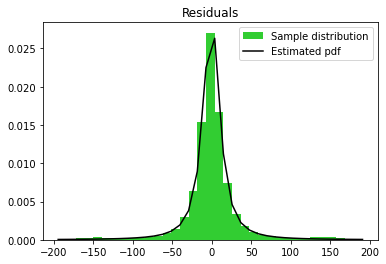

In [11]:
def prep_data_segmented(p, data, *args, **kwargs):
    X = np.zeros((0, p))
    y = np.zeros((0, 1))
    for segment in data:
        if len(segment) > p:
            lagged_segment = lagged_data(segment, p=p, add_intercept=False)
            X = np.concatenate([X, lagged_segment], axis=0)
            y = np.concatenate([y, segment[p:, np.newaxis]], axis=0)
    return X, y

angle_args = {
    "transform": sequential_angles,
    "prep_data": prep_data_segmented,
    "verbose": True
}
ar_angle_model = ARModel()
print("With AIC:")
ar_angle_model.fit(directions, IC=AIC, **angle_args)
print("\nWith BIC:")
ar_angle_model.fit(directions, IC=BIC, graph_residuals=True, nbins=35, **angle_args)

## Relations between stations

In [13]:
yul = stations.loc[YUL]
nyears = stations.last_y - stations.first_y
by_length = stations.assign(nyears=nyears).sort_values(['nyears'], ascending=False)
by_length = by_length.loc[
    (by_length.last_y > yul.first_y) |
    ((by_length.last_y == yul.first_y) & (by_length.last_m >= yul.first_m))
]
sample = by_length.iloc[:6]
sample

,first_m,first_y,last_m,last_y,lat,long,name,nyears
5616,10,1975,9,2012,45.67,-74.03,MONTREAL/MIRABEL INT'L A,37
10873,2,1994,4,2022,45.43,-73.93,STE-ANNE-DE-BELLEVUE 1,28
10762,2,1994,4,2022,45.17,-73.68,STE-CLOTILDE,28
10761,2,1994,4,2022,45.50,-73.58,MCTAVISH,28
5237,9,1994,4,2022,45.81,-73.43,L'ASSOMPTION,28
10843,2,1994,4,2022,45.29,-73.35,L'ACADIE,28


In [14]:
viz_map = Map(location=(yul.lat, yul.long), **MAP_ARGS)
for _, row in sample.iterrows():
    Marker((row.lat, row.long)).add_to(viz_map)
Marker((yul.lat, yul.long)).add_to(viz_map)
viz_map

In [15]:
data = {YUL: data}
for i, row in sample.iterrows():
    print(f"Downloading data for {row['name']} ({i})")
    station = StationData(row)
    station.load_data(
        min_year = yul.first_y,
        max_year = yul.last_y
    )
    data[i] = station.data

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.34it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 171/171 [00:17<00:00,  9.87it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 171/171 [00:17<00:00,  9.82it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 171/171 [00:17<00:00, 10.05it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:17<00:00,  9.58it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 171/171 [00:18<00:00,  9.32it/s]


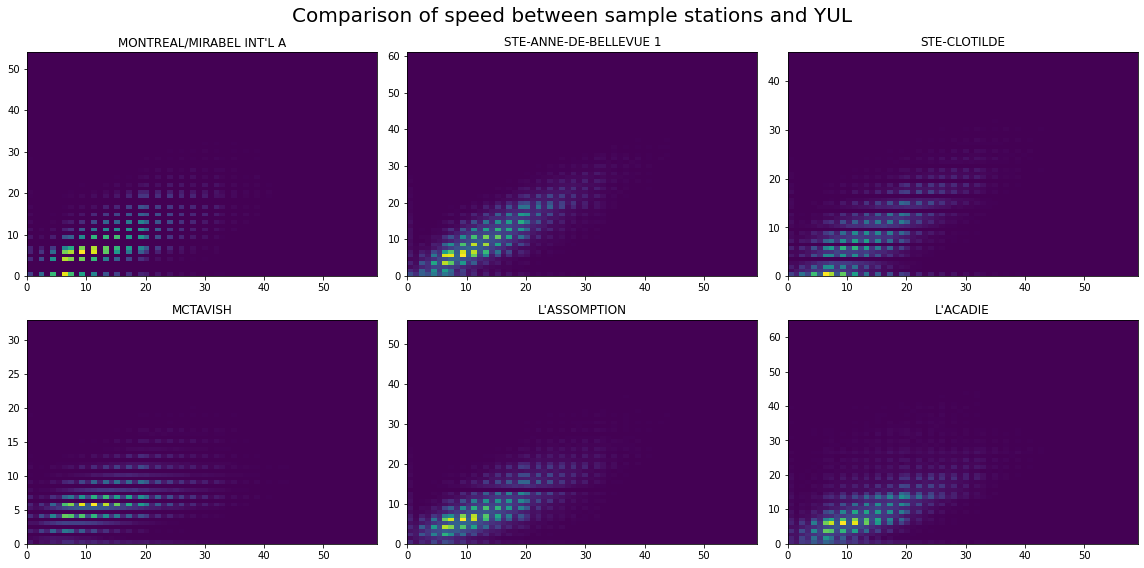

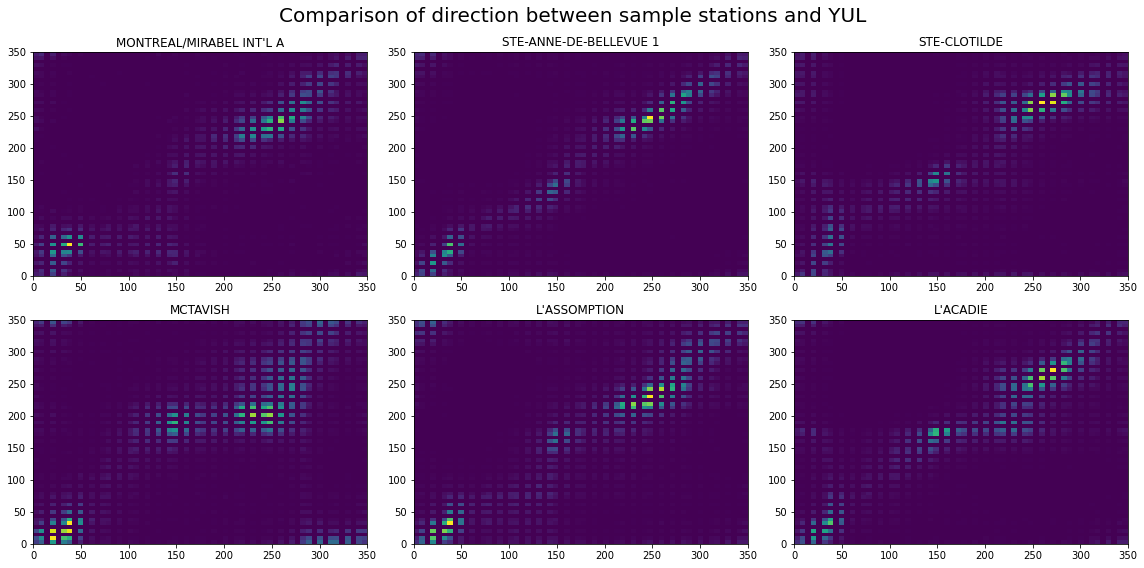

In [17]:
def bivariate_series(col: str,
                     keys: list,
                     data_dict: dict = data,
                     join_on: Union[str, list] = index_cols):
    sets = [data_dict[key] for key in keys]
    joined = pd.merge(*sets, how="inner", on=join_on, suffixes=keys)
    joined = joined[[col + str(key) for key in keys]].dropna()
    return joined.to_numpy()

for k, col in enumerate(['speed', 'direction']):
    axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))[1]
    for i, key in enumerate(sample.index):
        ax = axes[i // 3, i % 3]
        series = bivariate_series(col, keys=[YUL, key]).T
        #ax.scatter(*series, color = PLOT_COLOR, s = 1)
        ax.hist2d(*series, bins=(60,60))
        ax.set_title(sample.loc[key, 'name'])
    plt.suptitle(f"Comparison of {col} between sample stations and YUL", fontsize=20)
    plt.tight_layout()
    plt.show()